## Open FDA exploratory notebook



In [1]:
import requests
import os
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import time
from joblib import delayed, Parallel
import datetime
# helper functions:
import helpers
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

%matplotlib inline

### Helper functions:

In [242]:


def country_convert(s):
    
    if s =='YU':
        
        s = 'Yugoslavia'
    try:
        s = coco.convert(s, to ='short_name')
    
    except:
        pass
    
    return(s)




def days_between(d1, d2):
    
    if np.isnan(d1) or np.isnan(d2):
        
        return np.nan

    else:
    
        d1 = str(int(d1))

        d2 = str(int(d2))

    if len(d1) == 6:
        
        d1 = d1+'01'
        
    elif len(d1) == 4:
        
        d1 = d1 +'0101'
        
    if len(d2) == 6:

        d2 = d2+'01'

    elif len(d2) == 4:

        d2 = d2 +'0101'
    
    try:
        
        d1 = datetime.datetime.strptime(d1, "%Y%m%d")
        d2 = datetime.datetime.strptime(d2, "%Y%m%d")
    
        return abs((d2 - d1).days)
    except:
        return np.nan




def folium_map(data2, title = 'Rate of Life Theatening Conditions Across Countries'):
    # Make an empty map
    m = folium.Map(location=[20, 0], zoom_start=3,width=1500,height=800)
    
    title_html = '''
             <h3 align="left" style="font-size:20px"><b>''' + title + '''</b></h3>'''
    m.get_root().html.add_child(folium.Element(title_html))


    for i in range(0,len(data2)):
           folium.Circle(
              location=[data2['lat'][i], data2['lon'][i]],
              popup= data2['country'][i] + ': ' + str(round(100*data2['proportion'][i],2))+ '%',
              radius=data2['proportion'][i]*1000000,
              color='crimson',
            fill = True,
            fill_color='crimson').add_to(m)
    return m



================================================================================================================================================================================================
### Let's get a sense of the sample data:

- The sample of data we pulled has 63800 rows and 85 columns, with event dates ranging from January 2010 to March 2020. Note: the total data set consists of over 1.2 million records, so the data we are working with here is only a small representation of the complete picture

- There are quite a few columns with incomplete data, we'll need to do some data QC to select more useful features

- While some data is not missing, they may still be non-informative if e.g. there is only 1 unique value



### Read in data pulled from the API:

In [51]:
data = pd.read_csv('openFDA_data/data/combined_weekly_sample_20200515.csv');

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (10,23,29,31,41,55,62,65,66) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.shape

(63800, 81)

### How many variables are missing data?

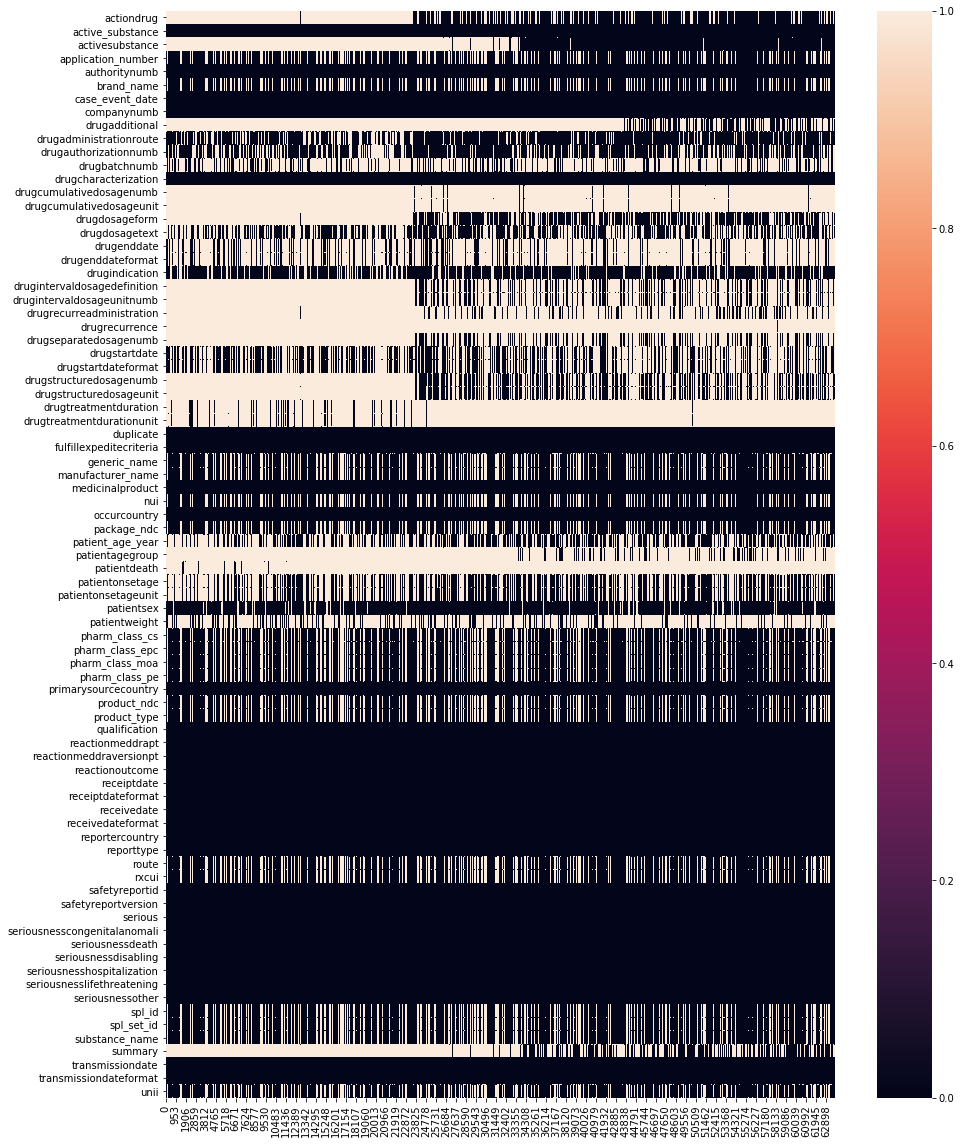

In [146]:
plt.figure(figsize=(15,20))
missing_data_count = sns.heatmap(data.isnull().transpose(), cbar = True)
plt.savefig('missing_data_count.png')
#sns.barplot(data_var)
#missing_data_count.savefig("missing_data_count.png")

### How many unique levels there are across the variables?

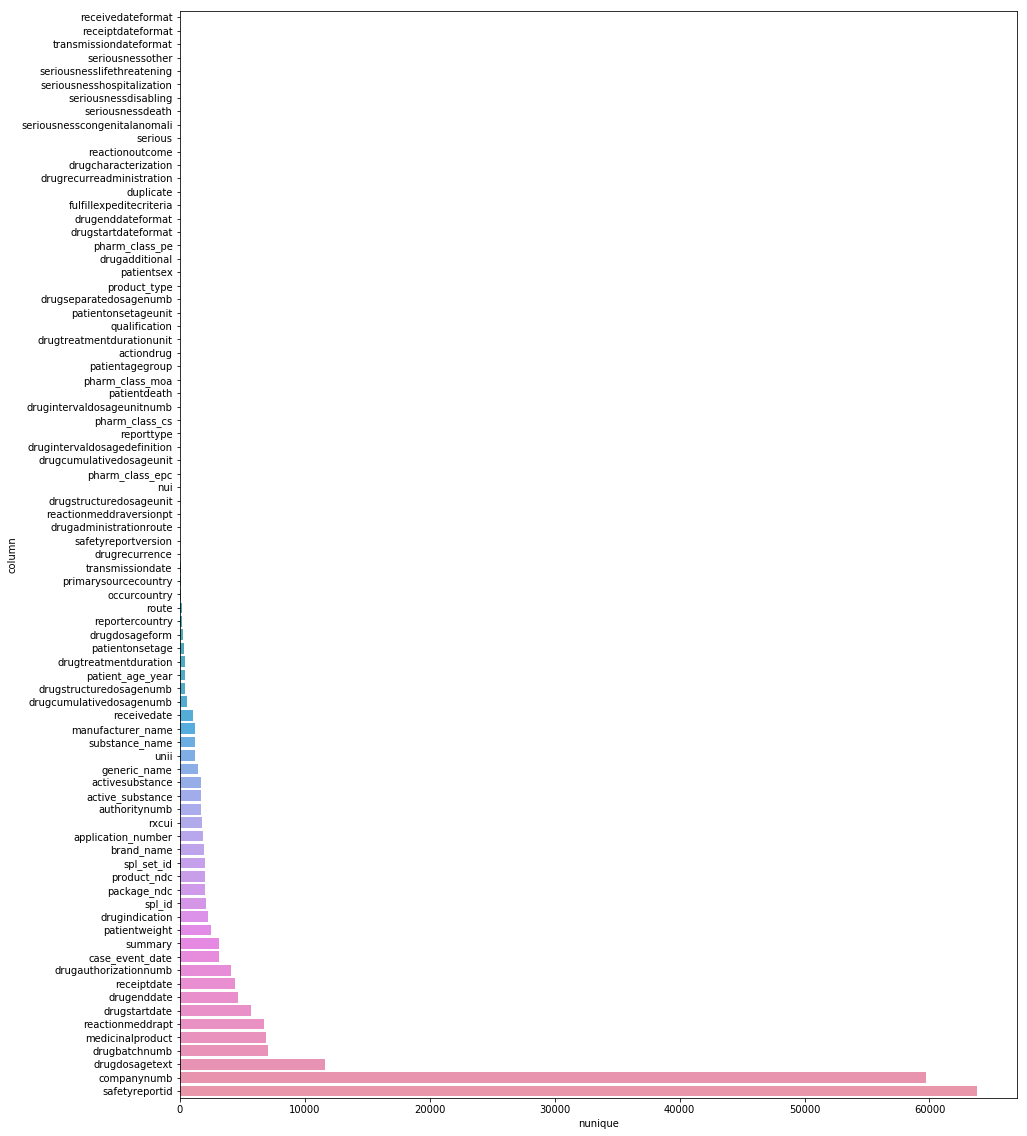

In [147]:
unique_levels = pd.DataFrame(data = {'column':data.columns,'nunique':data.nunique()}).sort_values('nunique')
plt.figure(figsize=(15,20))
sns.barplot(data=unique_levels, y ='column', x='nunique')
plt.savefig('unique_levels.png')

================================================================================================================================================================================================

### Data cleaning:

Horizontal (column): by dropping a feature using the following criteria:

- % of missing data > 80%

- has only 1 unique level

- represents a nested key (those were already unested in the previous data gathering function so information should be contained in other columns)




### Additional feature generation:

- patient age in years
- drug duration (taken as difference between `drugstartdate` and `drugenddate`, if exists
- lat and lon of reporter countries

In [154]:
missing_df = data.isnull()

missing_df_info = pd.DataFrame(data = {'missing_count':missing_df[missing_df==True].count(axis=0)/len(data)})


nested_keys = ['primarysource','sender','patient','receiver','reportduplicate','summary','patientdeath']
informative_vars1 = [val for val in set(missing_df_info[missing_df_info['missing_count']<0.8].index) - set(nested_keys) ]

informative_vars2 = [val for val in unique_levels[unique_levels['nunique']>1].index]

informative_vars = [val for val in informative_vars1  or informative_vars2]

data_subset = data[informative_vars]

data_subset.shape

(63800, 71)

### Let's take a look at the variables that got removed:

In [155]:
set(data.columns) - set(informative_vars)

{'drugadditional',
 'drugcumulativedosagenumb',
 'drugcumulativedosageunit',
 'drugrecurreadministration',
 'drugrecurrence',
 'drugtreatmentduration',
 'drugtreatmentdurationunit',
 'patientagegroup',
 'patientdeath',
 'summary'}

================================================================================================================================================================================================
## Now some data analysis to answer some high level questions:

### Overview: can we use the data to get some useful answers such as the following?

- **Product** 

    - what type of products are there?
    - what are the most common active ingredients?
    - which products are most associated with an adverse event?
    
- **Adverse events**

    - how often do we see an adverse events reported in this sample of data?
    - how wide-spread are these adverse events across countries?
    - given they are serious adverse events, what are the main reactions associated with it?

- **Patient**

    - what are the age and gender of the patients?
    - how long did they typically take the drug before a reaction happens?
    - what are some of the reactions associated with adverse events?
    - do we see these reactions more often in certain age group or gender?



### Product overview:


In [294]:

print('There are '+ str(data_subset['medicinalproduct'].nunique()) + ' unique medicincal product in this dataset, and '+ str(data_subset['active_substance'].nunique()) +' types of active substance')


There are 6869 unique medicincal product in this dataset, and 1672 types of active substance


Let's see the breakdown of productions by adverse events:

In [ ]:
data_subset

### Types of adverse events:



From the metadata, we know that the flag `serious` indicates whether or not the adverse events result in serious conditions which are: death, a life threatening condition, hospitalization, disability, congenital anomaly, and other. 



In [290]:
serious_flag = [val for val in data_subset.columns if 'seriousness' in val]

serious_flag

['seriousnesslifethreatening',
 'seriousnessdeath',
 'seriousnesshospitalization',
 'seriousnesscongenitalanomali',
 'seriousnessother',
 'seriousnessdisabling']

6869
1672


In [288]:
len(data_subset['drugdosagetext'].dropna())

34545

In [243]:
drug_duration = [ days_between(data_subset['drugstartdate'][i],data_subset['drugenddate'][i]) for i in range(0,len(data_subset))]

data_subset['drug_duration'] = drug_duration

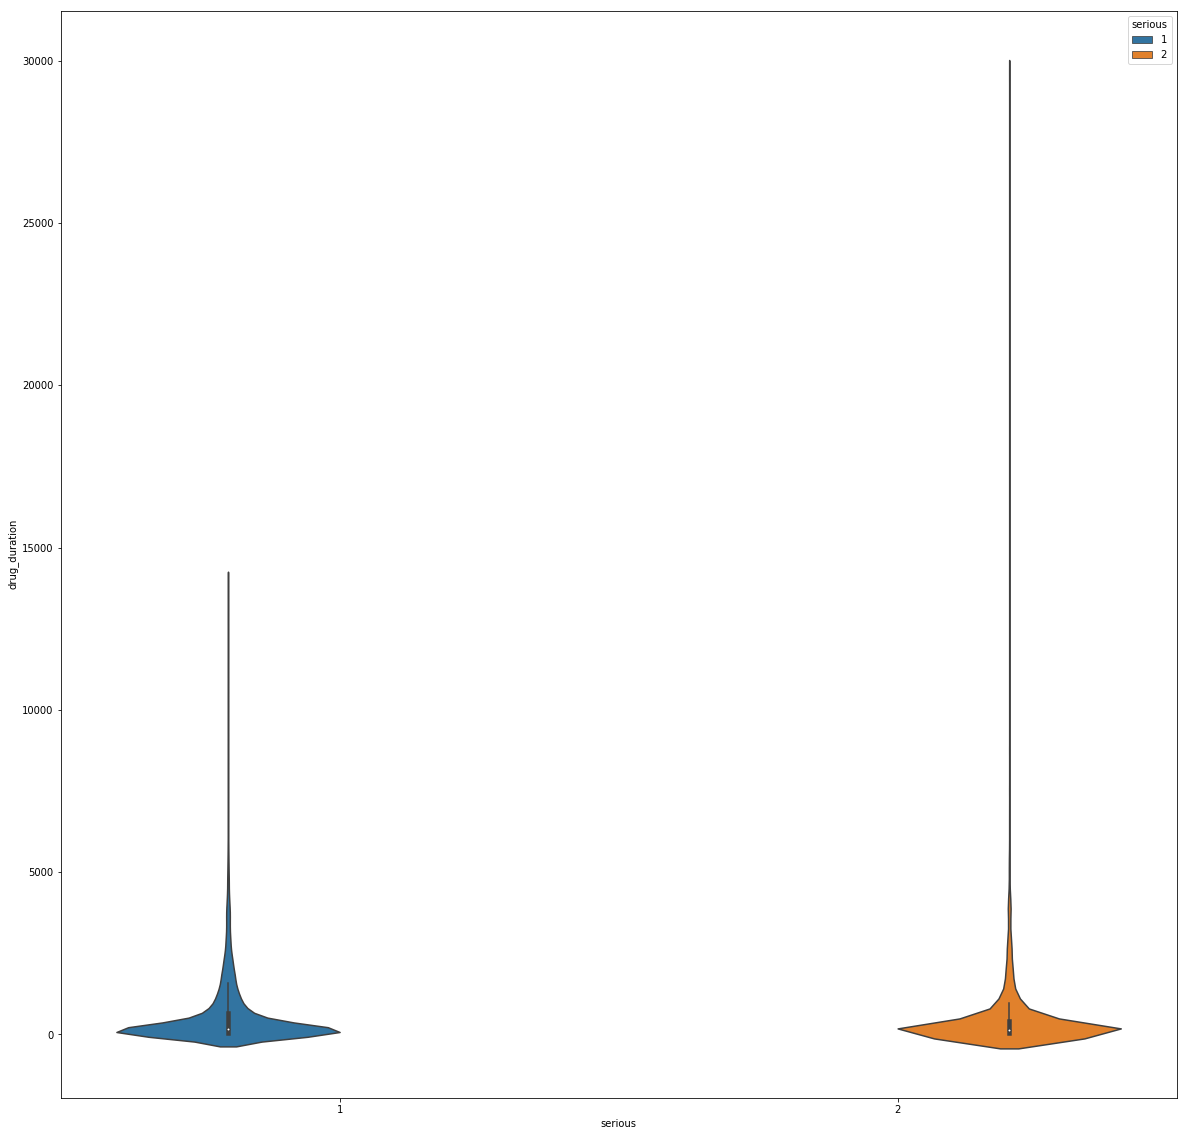

In [283]:
plt.figure(figsize=(20,20))
sns.violinplot(data= data_subset[data_subset['drug_duration']>10], x = 'serious', y = 'drug_duration', hue = 'serious' )

In [200]:
data_subset['active_substance'] = data_subset['active_substance'].fillna('UNKNOWN')

### Mapping adverse event rate across countries:
In order to visualize adverse events on a map, we need to standardize country names and get geocode (lat/lon), also, we'll only show countries that have at least 100 cases  

In [156]:

countries = data_subset['reportercountry'].unique()

countries_short = [country_convert(val) for val in countries]

country_lookup = pd.DataFrame(data = {'reportercountry':countries,'country_short':countries_short})

from geopy.geocoders import Nominatim
geolocator = Nominatim()
#import numpy as np

locs = [geolocator.geocode(c) for c in country_lookup['country_short']]



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Using Nominatim with the default "geopy/1.22.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


In [157]:
lat = [locs[i].latitude if locs[i] is not None else np.NaN for i in range(0,len(country_lookup))]
lon = [locs[i].longitude if locs[i] is not None else np.NaN  for i in range(0,len(country_lookup))]
country_lookup['lat'] = lat
country_lookup['lon'] = lon

In [159]:
data_subset = data_subset.merge(country_lookup)

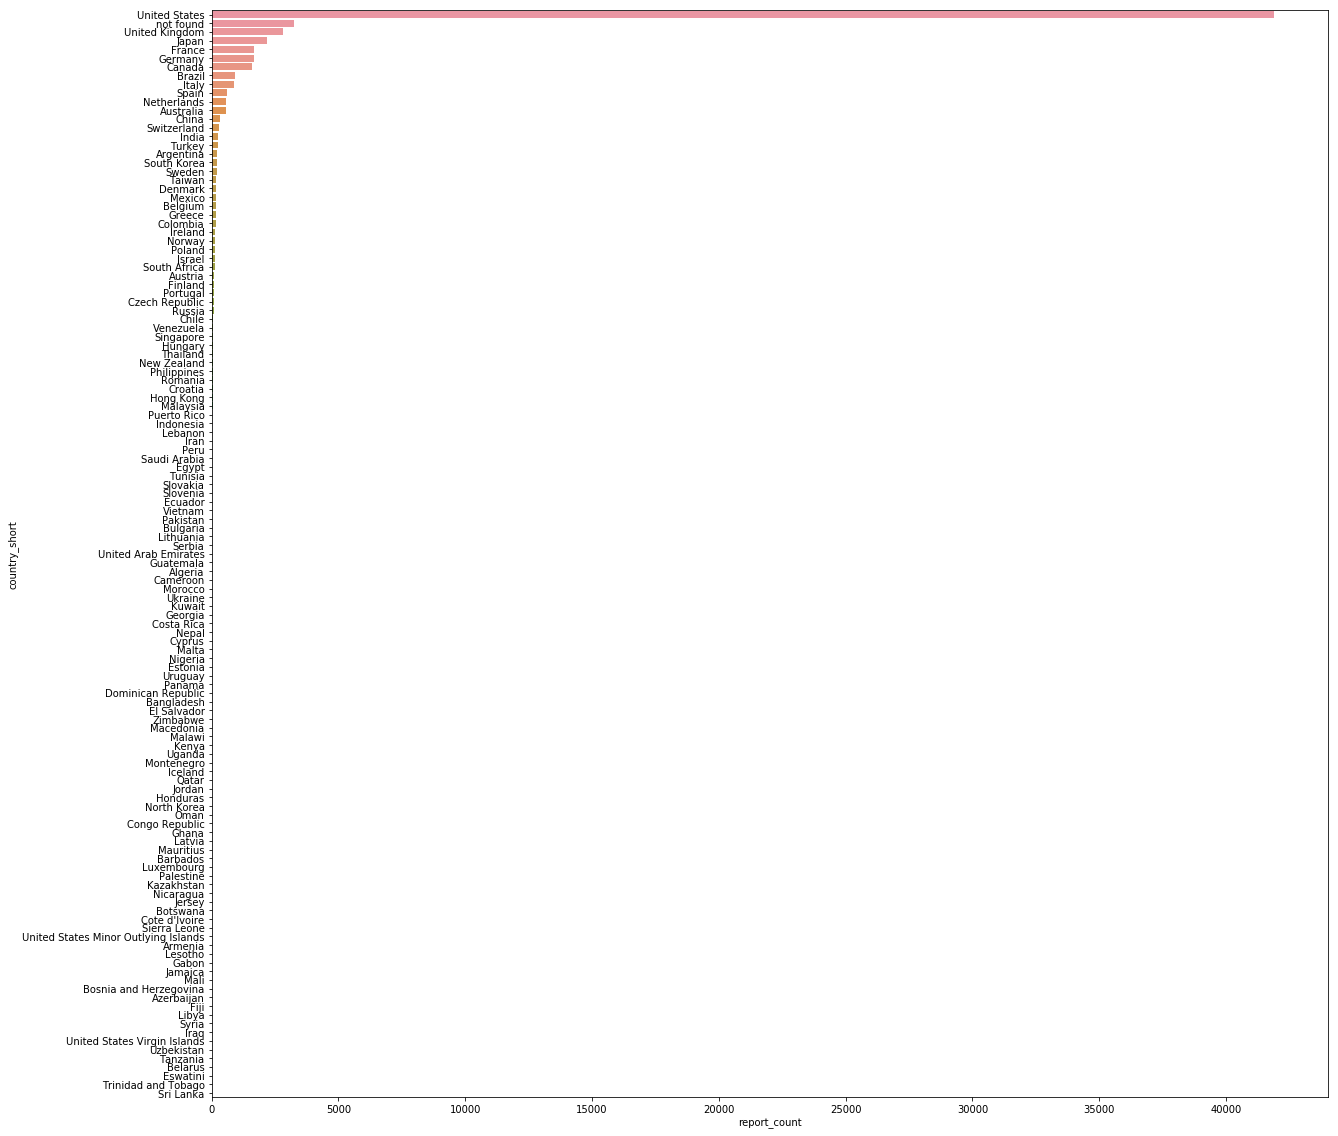

In [197]:
country_count = pd.DataFrame(data = data_subset['country_short'].value_counts()).reset_index()

country_count.columns = ['country_short','report_count']


plt.figure(figsize=(20,20))
sns.barplot(data = country_count, y = 'country_short', x = 'report_count')

In [198]:
data_subset2 =  data_subset.merge(country_count)

In [183]:
country_pivot = data_subset2[data_subset2['report_count']>100].pivot_table(values=serious_flags, columns=['country_short','lat','lon']).reset_index()

life_threatening = country_pivot[country_pivot['level_0']=='seriousnesslifethreatening']

life_threatening.columns = ['condition','country','lat','lon','proportion']


In [295]:
folium_map(data2=life_threatening, title = 'Rate of life threatening adverse effects')